In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# OptionMetrics data base available through the Wharton Research Data Services

Open the data:

In [2]:
df_options = pd.read_csv("D://Data/Options/f4c96ef74cf7492c.csv", sep=",")

In [14]:
df_options = df_options[df_options["volume"] != 0] # no volume, no real options

In [4]:
df_options.date = pd.to_datetime(df_options.date, format="%Y%m%d")
df_options.exdate = pd.to_datetime(df_options.exdate, format="%Y%m%d")

In [5]:
df_options.strike_price = df_options.strike_price / 100000

In [6]:
df_options["to_matur"] = df_options.exdate - df_options.date

Exmaple of the avaliable data:

In [7]:
df_options.sort_values("date", ascending=True).head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,index_flag,issuer,exercise_style,to_matur
128,2007-05-10,2007-12-22,C,1.38,1.45,1.70,2,0,0.049434,0.418867,0.073463,40.82416,-4.565195,32549447,0,CURRENCYSHARES EURO TR,A,226 days
31534,2007-05-10,2007-12-22,C,0.82,2.25,2.65,2,0,0.048378,0.741377,0.101836,20.41096,-3.907860,32549492,0,CURRENCYSHARES SWISS FRANC T,A,226 days
31523,2007-05-10,2007-09-22,C,0.82,1.65,1.90,10,0,0.054671,0.675453,0.131345,17.71416,-4.199652,32549506,0,CURRENCYSHARES SWISS FRANC T,A,135 days
129,2007-05-10,2007-12-22,C,1.39,1.15,1.40,5,0,0.051073,0.353716,0.067857,38.89334,-4.089529,32549451,0,CURRENCYSHARES EURO TR,A,226 days
130,2007-05-10,2007-12-22,C,1.40,0.85,1.10,2,0,0.051163,0.290748,0.062580,35.94629,-3.532333,32549452,0,CURRENCYSHARES EURO TR,A,226 days


## Statistical information

In [9]:
pd.DataFrame(df_options.groupby("issuer").date.count())

,date
issuer,
CURRENCYSHARES EURO TR,234761
CURRENCYSHARES SWISS FRANC T,23528
CURRENCYSHS BRIT POUND STER,40332


Result: th emost popular type is EUR/USD

In [13]:
pd.DataFrame(df_options.groupby("cp_flag").date.count())

,date
cp_flag,
C,130080
P,168541


Result: different number of Call and Put options

In [8]:
pd.DataFrame(df_options[df_options["issuer"] == "CURRENCYSHS BRIT POUND STER"].groupby(["date"]).date.count().head())

,date
date,
2007-05-17,13
2007-05-18,5
2007-05-21,3
2007-05-22,11
2007-05-23,1


Result: the same type of options (EUR) has several prices per day. Just different levels.

In [282]:
pd.DataFrame(df_options.groupby(["to_matur", "issuer"]).date.count()).sort_values(["date"], ascending=False).head(5)

,,date
to_matur,issuer,
8 days,CURRENCYSHARES EURO TR,4851
3 days,CURRENCYSHARES EURO TR,4716
1 days,CURRENCYSHARES EURO TR,4589
2 days,CURRENCYSHARES EURO TR,4556
4 days,CURRENCYSHARES EURO TR,4509


Result: the most frequent time to maturity is 8 days. Will use it for further analysis.

In [15]:
pd.DataFrame(df_options.groupby(["issuer"]).strike_price.describe())

,count,mean,std,min,25%,50%,75%,max
issuer,,,,,,,,
CURRENCYSHARES EURO TR,234761.0,1.258453,0.151441,0.65,1.125,1.28,1.36,2.1
CURRENCYSHARES SWISS FRANC T,23528.0,1.042337,0.122616,0.65,0.960,1.04,1.11,1.6
CURRENCYSHS BRIT POUND STER,40332.0,1.592202,0.185935,0.95,1.490,1.56,1.65,2.2


Result: here we have a wide range of avaliable strike prices (caution: the presented information covers the whole avaliable data set)

# Just an exchange rates:

## The most frequent: EUR

Read EUR/USD prices from a file:

In [96]:
df_EUR = pd.read_csv("D://Data/Options/Exchange_Rate/EURUSD_EET_Daily_Bid_2007.05.09_2016.04.27.csv", delimiter=",")
df_EUR["Time (UTC)"] = pd.to_datetime(df_EUR["Time (UTC)"])

In [289]:
selected_df = df_options[(df_options["issuer"] == "CURRENCYSHARES EURO TR") & (df_options["to_matur"] == "8 days") & (df_options["cp_flag"] == "P")]
uniqDates = selected_df.groupby(["date"]).date.count().index.tolist()

Here we try to find the closest to the at-the-money options for each given time step (day):

In [290]:
# Here we try to find the closest to the at-the-money options:
df_atTheMoney = pd.DataFrame()

for i, aDate in enumerate(uniqDates):
        
    openPrice = df_EUR[(pd.DatetimeIndex(df_EUR["Time (UTC)"]).year == uniqDates[0].year) & (pd.DatetimeIndex(df_EUR["Time (UTC)"]).month == uniqDates[0].month) & (pd.DatetimeIndex(df_EUR["Time (UTC)"]).day == uniqDates[0].day)].Open
    
    atTheMoney = selected_df[selected_df["date"] == aDate].iloc[(selected_df[selected_df["date"] == aDate]['strike_price']-openPrice).abs().argsort()[:1]]
    
    df_atTheMoney = pd.concat([df_atTheMoney, atTheMoney])

Build a plot for EUR/USD prices (black) and a curve for Put prices (brown and blue):

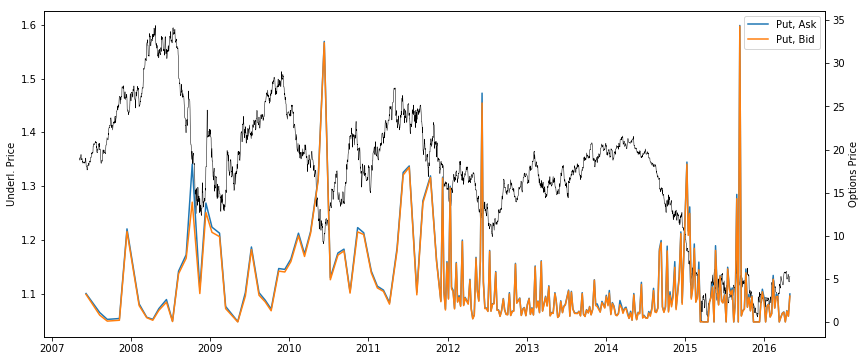

In [296]:
fig, ax = plt.subplots(figsize = (14,6))

ax.plot(df_EUR["Time (UTC)"], df_EUR.Open, linewidth=0.5, color="black")
#ax.plot(df_GBP["Time (UTC)"], df_GBP.High, linewidth=0.5)

ax.set_ylabel("Underl. Price")

ax2 = ax.twinx()

ax2.plot(df_atTheMoney["date"], df_atTheMoney.best_offer, label="Put, Ask")
ax2.plot(df_atTheMoney["date"], df_atTheMoney.best_bid, label="Put, Bid")

ax2.set_ylabel("Options Price")

ax2.legend()

plt.show()

** Results: the avaliable data is very badly fragmented, there is no sufficient information to make a decent research. We need real data on the option prices. Day by day, at-the-money. Various periods of maturity. **